Create a bollinger band mean reverting strategy

In [2]:
import sys
import timeit
import numpy as np
import pandas as pd
import pyfolio as pf

from statsmodels.tsa.stattools import adfuller

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix

from mlfinlab.corefns.core_functions import CoreFunctions
from mlfinlab.corefns.financial_functions import FinancialFunctions
from mlfinlab.fracdiff.fracdiff import frac_diff_ffd

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Read in data
data = pd.read_csv('official_data/dollar_bars.csv', nrows=40000)
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)

In [4]:
# Compute daily volatility
vol = CoreFunctions.get_daily_vol(close=data['close'], lookback=50)

Calculating daily volatility for dynamic thresholds


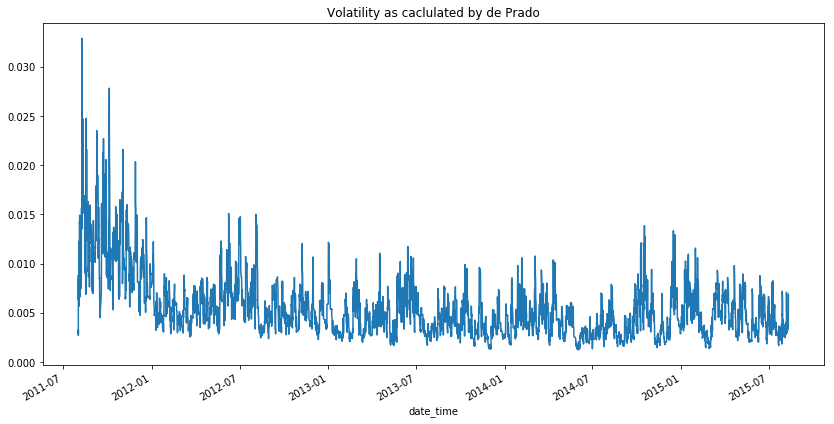

In [5]:
vol.plot(figsize=(14, 7), title='Volatility as caclulated by de Prado')
plt.show()

In [6]:
# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = CoreFunctions.get_t_events(data['close'], threshold=vol.mean())

Applying Symmetric CUSUM filter.


100%|███████████████████████████████████████████████████████████████████████████████| 39998/39998 [00:05<00:00, 7108.20it/s]


In [7]:
# Compute vertical barrier
vertical_barriers = CoreFunctions.add_vertical_barrier(cusum_events, data['close'])
vertical_barriers.head()

2011-08-01 10:51:41.842   2011-08-02 10:52:48.191
2011-08-01 13:36:46.215   2011-08-02 13:37:28.849
2011-08-01 14:00:21.448   2011-08-02 14:04:29.869
2011-08-01 14:03:22.782   2011-08-02 14:04:29.869
2011-08-01 14:21:49.179   2011-08-02 14:27:55.423
Name: date_time, dtype: datetime64[ns]

On those sampled features, apply the triple-barrier method, where ptSl=[1,1] and t1 is the series you created in point 1.b.

In [8]:
window = 50
rolling_mean, upper_band, lower_band = FinancialFunctions.bbands(data['close'], window, no_of_stdev=2)

In [9]:
from mlfinlab.corefns.financial_functions import FinancialFunctions

data.tail()
data_df = data.copy(deep=True).reset_index()
rsi = FinancialFunctions.relative_strength_index(data_df, 14)
rsi_df = pd.Series(data=rsi, index=data.index)
rsi_df.tail()

date_time
2015-08-10 13:40:00.351   NaN
2015-08-10 13:44:10.435   NaN
2015-08-10 13:49:44.719   NaN
2015-08-10 13:53:25.555   NaN
2015-08-10 14:00:07.700   NaN
Name: RSI_14, dtype: float64

In [10]:
# create the data frame
signal_df = data['close'].to_frame()
signal_df['avg'] = rolling_mean
signal_df['upper'] = upper_band
signal_df['lower'] = lower_band
signal_df['rsi'] = pd.Series(data=rsi_df.values, index=signal_df.index)
signal_df['side'] = 0.0

signal_df.tail()

,close,avg,upper,lower,rsi,side
date_time,,,,,,
2015-08-10 13:40:00.351,2090.00,2072.420,2086.656143,2058.183857,NaN,0.0
2015-08-10 13:44:10.435,2092.25,2072.645,2087.762934,2057.527066,NaN,0.0
2015-08-10 13:49:44.719,2092.50,2072.995,2089.112708,2056.877292,NaN,0.0
2015-08-10 13:53:25.555,2093.00,2073.380,2090.462107,2056.297893,NaN,0.0
2015-08-10 14:00:07.700,2093.25,2073.800,2091.777878,2055.822122,NaN,0.0


In [11]:
# Apply Bolinger band strategy
"""
The following is a mean reverting strategy using Bollinger Bands:
* If price above upper band then short.
* If price below bottom band then long.
* If price cross mean price then close all positions.
"""
current_side = 0

store = []
for row in signal_df.itertuples():
        # Buy signal
        if row.close > row.upper and current_side != -1:
            current_side = -1
            store.append(current_side)
            
        # Short signal
        elif row.close < row.lower and current_side != 1:
            current_side = 1
            store.append(current_side)
        
        # Close signal long
        elif current_side == 1 and row.close > row.avg:
            current_side = 0
            store.append(current_side)
            
        # Close signal short
        elif current_side == -1 and row.close < row.avg:
            current_side = 0
            store.append(current_side)
            
        # No action
        else:
            store.append(current_side)
            
signal_df['side'] = store

In [12]:
signal_df['side'].value_counts()

 0    15311
-1    13407
 1    11282
Name: side, dtype: int64

In [13]:
# extract side as a series 
side = signal_df['side']
bb_events = CoreFunctions.get_events(data['close'],                                     
                                     t_events=cusum_events,
                                     pt_sl=[0, 2],
                                     target=vol,
                                     min_ret=0.01,
                                     num_threads=1,
                                     vertical_barrier_times=vertical_barriers,
                                     side=side)

D:\Documents\WQU\Courses\14 - Capstone 690\cs\research\2019-03-03_AS_JJ_Chapter3\mlfinlab\corefns\core_functions.py:205: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]


In [14]:
bb_events.tail()
bb_events.side.value_counts()

 0.0    247
 1.0    209
-1.0    204
Name: side, dtype: int64

In [38]:
labels = CoreFunctions.get_bins(bb_events, data['close'])

In [16]:
print(labels.head())
labels.bin.value_counts()

                              ret      trgt  bin
2011-08-04 01:57:00.466  0.052138  0.011841    1
2011-08-04 09:08:28.542  0.047848  0.012108    1
2011-08-04 10:27:24.326  0.000000  0.011682    0
2011-08-04 12:29:39.619  0.000000  0.011022    0
2011-08-04 19:44:06.743 -0.023280  0.011423    0


0    570
1     90
Name: bin, dtype: int64

In [17]:
fracs = frac_diff_ffd(data['close'].apply(np.log), differencing_amt=0.23, threshold=1e-5)

result = adfuller(fracs, maxlag=2, regression='C', autolag='AIC', store=False, regresults=False)
print('ADF Statistic: %f' % abs(round(result[0], 3)))
print('p-value: %f' % result[1])
print('Critical values:')
for k, v in result[4].items():
    print('\t%s: %.3f' % (k, v))

ADF Statistic: 3.467000
p-value: 0.008877
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [18]:
# compute features - fracdiff
# frac_df = pd.DataFrame(data=fracs, index=data.index, columns=['fracdiff'])
frac_df = pd.Series(data=fracs, index=data.index)
frac_df.tail()

date_time
2015-08-10 13:40:00.351    1.010389
2015-08-10 13:44:10.435    1.011332
2015-08-10 13:49:44.719    1.011051
2015-08-10 13:53:25.555    1.011034
2015-08-10 14:00:07.700    1.010918
dtype: float64

In [19]:
autocorr_df = CoreFunctions.get_autocorr(data['close'])
autocorr_df.tail()

Calculating Daily AutoCorr


date_time
2015-08-10 13:40:00.351    0.952725
2015-08-10 13:44:10.435    0.959176
2015-08-10 13:49:44.719    0.963645
2015-08-10 13:53:25.555    0.966879
2015-08-10 14:00:07.700    0.969853
Name: close, dtype: float64

In [20]:
# Create feature matrix
X = pd.DataFrame(labels['trgt'])
X['side'] = [bb_events['side'][x] for x in X.index]
X['autocorr'] = [autocorr_df[x] for x in X.index]
# X['rsi'] = [rsi_df[x] for x in X.index]
X['fracdiff'] = [frac_df[x] for x in X.index]
print(X.tail())

                             trgt  side  autocorr  fracdiff
2015-01-15 13:45:55.324  0.010148  -1.0  0.946103  1.007929
2015-01-15 14:39:34.621  0.010703  -1.0  0.953590  0.998536
2015-01-30 10:09:09.112  0.011492  -1.0  0.972075  0.998414
2015-01-30 14:48:27.262  0.010769   0.0  0.974584  1.003346
2015-01-30 15:34:17.075  0.010072   0.0  0.977874  0.997364


In [21]:
# extract y values
y = labels.bin.to_frame()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [23]:
n_estimator = 10000
c_random_state = 42

rf = RandomForestClassifier(max_depth=5, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

Performance Training

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       451
           1       0.89      0.42      0.57        77

   micro avg       0.91      0.91      0.91       528
   macro avg       0.90      0.70      0.76       528
weighted avg       0.91      0.91      0.89       528

Confusion Matrix
[[447   4]
 [ 45  32]]


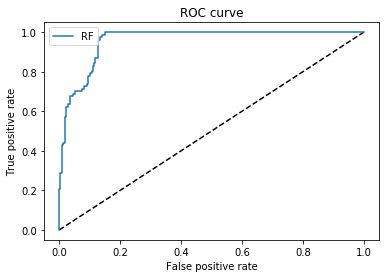

In [24]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Performance: Test

C:\Users\Asingh\Anaconda3\envs\p36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95       119
           1       0.00      0.00      0.00        13

   micro avg       0.90      0.90      0.90       132
   macro avg       0.45      0.50      0.47       132
weighted avg       0.81      0.90      0.85       132

Confusion Matrix
[[119   0]
 [ 13   0]]


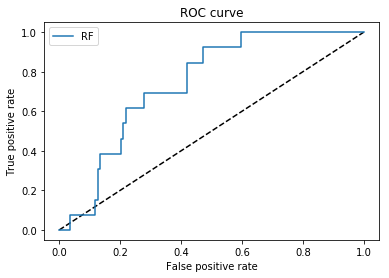

In [25]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Returns Tearsheet

In [75]:
# print(labels.head())
# strategy = labels.copy(deep=True)
# strategy.index = pd.to_datetime(strategy.index).tz_localize('US/Eastern')

# strategy = pd.DataFrame(data=labels['ret'].values, columns=['ret'])
# strategy.index = pd.to_datetime(labels.index).tz_localize('US/Eastern')
# strategy.head()

strategy = labels['ret'].copy(deep=True)
strategy.index = strategy.index.tz_localize('US/Eastern')
# strategy.index = pd.to_datetime(strategy.index)
print(strategy.head())

660
660
2011-08-04 01:57:00.466000-04:00    0.052138
2011-08-04 09:08:28.542000-04:00    0.047848
2011-08-04 10:27:24.326000-04:00    0.000000
2011-08-04 12:29:39.619000-04:00    0.000000
2011-08-04 19:44:06.743000-04:00   -0.023280
Name: ret, dtype: float64


In [74]:
pf.create_returns_tear_sheet(strategy, benchmark_rets=None)

Entire data start date: 2011-08-04
Entire data end date: 2015-01-30


Backtest Months: 31


KeyError: "None of [DatetimeIndex(['2011-08-04 01:57:00.466000-04:00',\n               '2011-08-04 09:08:28.542000-04:00',\n               '2011-08-04 10:27:24.326000-04:00',\n               '2011-08-04 12:29:39.619000-04:00',\n               '2011-08-04 19:44:06.743000-04:00',\n               '2011-08-04 20:01:48.966000-04:00',\n               '2011-08-04 22:01:00.701000-04:00',\n               '2011-08-05 06:36:24.009000-04:00',\n               '2011-08-05 07:37:13.880000-04:00',\n               '2011-08-05 08:31:30.648000-04:00',\n               ...\n               '2014-12-15 16:26:00.188000-05:00',\n               '2014-12-16 17:51:41.035000-05:00',\n               '2014-12-18 10:21:29.941000-05:00',\n               '2014-12-18 17:51:24.816000-05:00',\n               '2015-01-09 17:13:19.851000-05:00',\n               '2015-01-15 13:45:55.324000-05:00',\n               '2015-01-15 14:39:34.621000-05:00',\n               '2015-01-30 10:09:09.112000-05:00',\n               '2015-01-30 14:48:27.262000-05:00',\n               '2015-01-30 15:34:17.075000-05:00'],\n              dtype='datetime64[ns, US/Eastern]', length=660, freq=None)] are in the [index]"